<a href="https://colab.research.google.com/github/cgbartnik/comparison_between_visual_saliency_maps_of_CNN_and_those_of_human_beings/blob/master/Introduction_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Comparison between Visual Saliency Maps of Convolutional Neural Networks and those of Human Beings: A Study on Facial Expression Recognition

**Overview**
-----------------
This Notebook is part of the master thesis of Clemens Bartnik and contains the code and instructions to run the code involved in the thesis. This notebook conains the code to preprocess the Data, train the network, evaluate the network, evalute the eye-tracking experiment and compare both approaches. 

**Abstract**

This master thesis uses facial expression recognition of the six basic emotions as ground to compare the salient regions used by a CNN and 28 human subjects in a head to head comparison on the same set of facial expression images. Because no state of the art CNN for facial expression recognition was suitable for the targeted comparison, a VGG Face CNN originally trained for face recognition was fine tuned by transfer learning for facial expression recognition. The regions that were most relevant for the network's prediction were visualised using the propagation based explanation method LRP. The salient regions on which the human subjects focused their visual attention were recorded by eye tracking and visualized in heatmaps. The comparison of both visual saliency maps was done by perturbation analysis. It was determined that the CNN and the human subjects focused on different salient regions when classifying the facial expressions. An additional visual inspection of each class of expression suggests that some classes contribute more than others to the overall difference. 

# Preprocessing

In [ ]:
import os #for acess to the operating system and loops over directories
import sys #for system stuff noch umschreiben 
import cv2 # open-cv for image cropping, loading and Viola-Jones- Algorithm 
import random

import numpy as np #algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for showing and plotting the images

In this thesis we use the **KDEF Database**. This can be found and downloaded at (http://kdef.se/).

The KDEF database is a publicly available dataset containing 4900 colored pictures of human facial expressions from 70 individuals (35 females and 35 males). All individuals are caucasian amateur actors (mean age: 25 years; range: 20-30 years) and were instructed to pose different emotional expressions: afraid, angry, disgusted, happy, neutral, sad and surprised. The pictures were taken in two sessions and each expression is available from five different angles (full left profile, half left profile, straight, half right profile, and full right profile). For this master thesis, only the subset of 980 facial expressions, displaying the straight viewing condition, was used. The dataset contains images from two photo sessions (A & B).  

After downloading and extracting the KDEF dataset you need to assign the path.

In [ ]:
data_dir = "/content/gdrive/My Drive/Thesis/KDEF/"   

## Sampling of the test-persons

For the fair comparioson we need a testset on which we can test the networks and the human participants performance. 

In this whole Thesis only a subset of the whole KDEF-Dataset is used. We restrict the selection of the pictures on the streight viewing condition. The subset contains all 70 individuals with all 7 expressions from both photographing sessions. (70 * 7 * 2 = 980 Pictures)

Out of this subset of the whole KDEF-dataset we randomly pick 16 different indivduals for our testingset. (16 * 7 = 112 Pictures) Our testing set contains 112 pictures. Because the emotion pictures of the different sessions are very close to each other and the testset should be in a leave-one-subject-out manner. We also exclude the pictures of the aquivalent individuals in the other phtographing session. 

The pictures for the testset are stored in the variable *test_set* and the not used duplicates in the variable *dublicates_test*.

In [ ]:
def random_number(seed,number,group,dublicate):
    """
    Function to generate random numbers for the sampling of the test actors
    :param seed: a number that specifies the seed 
    :param number: the amount of random numbers that are sampled
    :param group: string, to match the IDs in the KDEF database. A for first
                  photo session; B for the second photo session
    :param dublicate: string of the second group to generate the IDs for the 
                      dublicate images.
    """
    dublicates_test = []
    test_set = []
    random.seed(seed)
    sample = random.sample(range(1,35), number)
    for i in sample:
        if len(str(i)) == 1:
            i = "0" + str(i)
    
        person_1 = str(group)+ str(i)
        person_1_D = str(dublicate)+ str(i)
        test_set.append(person_1)
        dublicates_test.append(person_1_D)
    return test_set,dublicates_test

In [ ]:
test_f, dublicate_f = random_number(1,8,"AF","BF")   # the seed used is 1 
test_m, dublicate_m = random_number(2,8,"AM","BM")   # the seed used is 2

testset = test_f + test_m
dublicatesset = dublicate_f + dublicate_m

In [ ]:
print(testset)

['AF09', 'AF05', 'AF17', 'AF04', 'AF16', 'AF25', 'AF15', 'AF30', 'AM04', 'AM06', 'AM33', 'AM12', 'AM27', 'AM32', 'AM24', 'AM26']


The testset for the experiment is comprised 16 subjects of the KDEF database with respectivly 7 images of facial expressions.  

This are the subjects:


**AF09, AF05, AF17, AF04, AF16, AF25, AF15, AF30, AM04, AM06, AM33, AM12, AM27, AM32, AM24, AM26**




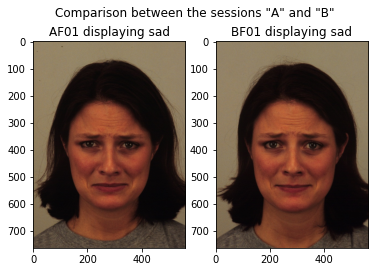

In [ ]:
img_A = cv2.imread(data_dir + "AF01/AF01SAS.JPG", cv2.COLOR_BGR2RGB)
img_B = cv2.imread(data_dir + "BF01/BF01SAS.JPG", cv2.COLOR_BGR2RGB)

fig, axarr = plt.subplots(1, 2)
fig.suptitle('Comparison between the sessions "A" and "B"')
plt.sca(axarr[0])
plt.title('AF01 displaying sad')
axarr[0].imshow(cv2.cvtColor(img_A, cv2.COLOR_BGR2RGB))
plt.sca(axarr[1])
plt.title('BF01 displaying sad')
axarr[1].imshow(cv2.cvtColor(img_B, cv2.COLOR_BGR2RGB))

plt.show(fig)

Because the pictures from the first and the second photographing session are very similar the responding dublices are excluded from the training set.

In [ ]:
print(dublicatesset)

['BF09', 'BF05', 'BF17', 'BF04', 'BF16', 'BF25', 'BF15', 'BF30', 'BM04', 'BM06', 'BM33', 'BM12', 'BM27', 'BM32', 'BM24', 'BM26']


Helper funtions to compare the lists of participants.

In [ ]:
def equal_elements(t1, t2):
    return list(set(t1).intersection(set(t2)))

def not_equal_elements(t1, t2):
    return list(set(t1).symmetric_difference(set(t2)))

In [ ]:
# Defining Variables
all_participants = []   # List of all Participants. 2 * 70 = 140 (70 for session A and 70 for session B)
test_pathes = []        # List of the pathes with the testing images. 16 * 7 = 112 Pathes
train_pathes = []       # List of the training pathes. (70 - 16) * 7 * 2 = 756 // in this way also the 112 dublicates are excluded
all_out = testset + dublicatesset  # in this variable all excluded images are stored. (the ones in the testset and the not used dublicates)


## Loop for train set (112  pictures)
for participant in os.listdir(data_dir): # loops over every particpant in the KDEF-Dataset directory (70)
    all_participants.append(participant) # appending the participants to the list with all participants. 
    if participant in equal_elements(all_participants, testset): # loop over all participants and check if they are in the testset: if Yes load the pictures
        for pictures in os.listdir(os.path.join(data_dir,participant)): # loops over every picture in the every participant folder
            if pictures[-5] == "S": #selects only the pictures containing an S at the last position indicating the straight viewing condition
                test_pathes.append(os.path.join(data_dir,participant, pictures))  # appending the full image path to the test_pathes list         

                
## Loop for train set (756  pictures)
for participant in all_participants:
    if participant in not_equal_elements(all_participants, all_out): # check if the participant is not in the testset or the dublicates set.
        for pictures in os.listdir(os.path.join(data_dir,participant)):
            if pictures[-5] == "S":
                train_pathes.append(os.path.join(data_dir,participant, pictures))


print("After loading:")
print("Trining images:", len(train_pathes))
print("Testing images:", len(test_pathes))

After loading:
Trining images: 753
Testing images: 112


The Variables containing the pathes for the training- and testsingset are now used to load in the pictures and futher preprocess and cropp them to fit the requirements of the pre-trained VGG-Face model.

The next cell block loops over every image path in the image_pathes list. 
1. Opens the picture, extracts the face using the Viola-Jones-Face Detection Algorithm with Face Cascades. Then uses the so found rectangluar Region of Intrest (ROI), extend it by 20 pixel on the side (XX) and (XX) and cuts 20 pixel of the side (XX) and (XX) and uses this Box to crop the original picture.  
2. The Image name gets sorted by the emotion expression abbrevations and the right number gets appended to a list. 
3. The list-variable "training_data" gets filled with the img_array and the numeric labels 
4. If an Exeption accures the loop prints an error and counts the errors. 

In [ ]:
cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/Thesis/haarcascade_frontalface_default.xml') 
#the localisation of the cascade haar filter used to identify the faces in the images

## Training-set Block

In the next code cell you should select a Directory where the cropped images should be saved. **(Not activated)**

In [ ]:
# Train directory
os.chdir("/content/gdrive/My Drive/Thesis/Train")

In [ ]:
count = 0   # counter 
error = 0   # error counter

cropped_train_arrays = []
label = []
label_num = []
ID = []
image_path = []

for picture in train_pathes:
    print("Trying to load image", picture)
    try:
        img_array = cv2.imread(picture, cv2.COLOR_BGR2RGB)
        faces_rect = cascade.detectMultiScale(img_array, scaleFactor = 1.3, minNeighbors = 6)
        for (x, y, w, h) in faces_rect:
            img_array = img_array[y-20:y+h+20,x-20:x+w+20] 
        img_array = cv2.resize(img_array,(224,224))
        #hier Histrogram equbilization
        
        # extract the emotion label expressed on the picture from the filename
        if picture[-7:-5] == "AF":
            labels = "afraid"
            labels_num = 1
        elif picture[-7:-5] == "AN":
            labels = "angry"
            labels_num = 2
        elif picture[-7:-5] == "DI":
            labels = "disgusted"
            labels_num = 3
        elif picture[-7:-5] == "HA":
            labels = "happy"
            labels_num = 4
        elif picture[-7:-5] == "SU":
            labels = "surprise"
            labels_num = 5
        elif picture[-7:-5] == "SA":
            labels = "sad"
            labels_num = 6
        else:
            labels = "neutral"
            labels_num = 7
            

        cropped_train_arrays.append(img_array) # without labels
        
        # count variable for the ID
        count += 1 
        
        #appending additional variables for the simuli.csv 
        label.append(labels)           # label of the shown expression (as words)
        label_num.append(labels_num)   # label of the shown expression (numeric)
        ID.append(count)               # ID 
        
        #saving the image in the specified training path
        cv2.imwrite(picture[-11:-4]+ ".png", img_array)    # needs to be uncommentet if the files should be safed speratly in the above defined folders
        
        cropped_path = "/home/cb/masterarbeit/cropped_data/Train/" +  picture[-11:-4] + ".png"
        image_path.append(cropped_path)
        print("Sucessfully loaded and saved image:", count)
        
    except Exception as e:
        error +=1
        print("Error for", picture)
        print("Error number:", error)
        pass

In [ ]:
train_data = {'Image_ID':ID, 'Image':image_path, 'label':label, 'label_num':label_num}
train_dataframe = pd.DataFrame(train_data)

In [ ]:
train_csv_file_path = "/content/gdrive/My Drive/Thesis/Train_Test_CSV/"
os.chdir(train_csv_file_path)

In [ ]:
train_dataframe.to_csv("train_data.csv", sep=',', encoding='utf-8')

## Test-set Block

In [ ]:
# Test directory
os.chdir("/content/gdrive/My Drive/Thesis/Test")

In [ ]:
count = 0   # counter 
error = 0   # error counter

cropped_test_arrays = []
label = []
label_num = []
ID = []
sex_in_image = []
image_path = []

for picture in test_pathes:
    print("Trying to load image", picture)
    try:
        img_array = cv2.imread(picture, cv2.COLOR_BGR2RGB)
        faces_rect = cascade.detectMultiScale(img_array, scaleFactor = 1.3, minNeighbors = 6)
        for (x, y, w, h) in faces_rect:
            img_array = img_array[y-20:y+h+20,x-20:x+w+20] 
        #img_array = cv2.resize(img_array,(224,224))
        
        # extract the emotion label expressed on the test stimuli from the filename
        if picture[-7:-5] == "AF":
            labels = "afraid"
            labels_num = 1
        elif picture[-7:-5] == "AN":
            labels = "angry"
            labels_num = 2
        elif picture[-7:-5] == "DI":
            labels = "disgusted"
            labels_num = 3
        elif picture[-7:-5] == "HA":
            labels = "happy"
            labels_num = 4
        elif picture[-7:-5] == "SU":
            labels = "surprise"
            labels_num = 5
        elif picture[-7:-5] == "SA":
            labels = "sad"
            labels_num = 6
        else:
            labels = "neutral"
            labels_num = 7
        
        # extract the sex of the show person on the test stimuli from the filename
        if picture[-10] == "M":
            sex = "male"
        else: 
            sex = "female"
        
        # count variable for the ID
        count += 1 
        
        # appending the array of the testimage to the list with all images     
       
        #appending additional variables for the simuli.csv 
        label.append(labels)           # label of the shown expression (as words)
        label_num.append(labels_num)   # label of the shown expression (numeric)
        sex_in_image.append(sex)       # sex of the person
        ID.append(count)               # ID 
        
        
        
        #saving the image in the specified test path
        cv2.imwrite(picture[-11:-4]+ ".png", img_array)    
        
        cropped_path = "/home/cb/masterarbeit/cropped_data/Test/" +  picture[-11:-4] + ".png"
        image_path.append(cropped_path)
        
        print("Sucessfully loaded and saved image:", count)
        
    except Exception as e:
        error +=1
        print("Error for", picture)
        print("Error number:", error)
        pass

Creating a pandas Dataframe with the test image IDs, full image pathes, labels as words and numerics and the sex of the person displayed on the test stimuli. 

This Dataframe will be written to a csv and then used in the Eye-Tracking Experiment

In [ ]:
test_data = {'Image_ID':ID, 'Image':image_path, 'label':label, 'label_num':label_num, 'sex':sex_in_image}
test_dataframe = pd.DataFrame(test_data)

In [ ]:
os.chdir("/content/gdrive/My Drive/Thesis/Train_Test_CSV/")

In [ ]:
test_dataframe.to_csv("test_data.csv", sep=',', encoding='utf-8')